In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%env JOBLIB_TEMP_FOLDER=/tmp
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

env: JOBLIB_TEMP_FOLDER=/tmp
/kaggle/input/shops.csv
/kaggle/input/item_categories.csv
/kaggle/input/sales_train.csv
/kaggle/input/items.csv
/kaggle/input/sample_submission.csv
/kaggle/input/test.csv


In [2]:
items = pd.read_csv('../input/items.csv')
shops = pd.read_csv('../input/shops.csv')
cats = pd.read_csv('../input/item_categories.csv')
train = pd.read_csv('../input/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('../input/test.csv').set_index('ID')

# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11


shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]


cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

In [3]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]
train = train.join(items, on='item_id', rsuffix='_').drop(['item_name','item_id_'],axis=1)
train['revenue_day']=train['item_price']*train['item_cnt_day']
train = train.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train = train.agg({'revenue_day':['sum'], 'item_price':['mean'],'item_cnt_day':['sum','mean','count']})
train.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'revenue','item_price', 'item_cnt', 'mean_item_cnt', 'transactions']


In [4]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    for shop in sales.shop_id.unique():
        for item in sales.item_id.unique():
            matrix.append(np.array([i, shop, item], dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
test['date_block_num']=34
matrix=pd.concat([matrix, test], ignore_index=True)
#matrix.sort_values(cols,inplace=True)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [5]:
matrix = pd.merge(matrix,train, on=['date_block_num','shop_id','item_id'], how='left')
matrix['item_cnt'] = (matrix['item_cnt']
                                .fillna(0)
                                .astype(np.float16))

In [6]:
group = train.groupby(['date_block_num', 'item_id'], as_index=False).agg({'item_price':['mean']})
group.columns = ['date_block_num', 'item_id','item_date_mean_price']
matrix = pd.merge(matrix,group, on=['date_block_num','item_id'], how='left')

In [7]:
group = train.groupby(['item_id'], as_index=False).agg({'item_price':['mean']})
group.columns = ['item_id','item_mean_price']
matrix = pd.merge(matrix,group, on=['item_id'], how='left')



group = train.groupby(['date_block_num', 'shop_id'], as_index=False).agg({'item_cnt':['mean']})
group.columns = ['date_block_num', 'shop_id','shop_cnt']
matrix = pd.merge(matrix,group, on=['date_block_num','shop_id'], how='left')
group = train.groupby(['date_block_num', 'item_id'], as_index=False).agg({'item_cnt':['mean']})
group.columns = ['date_block_num', 'item_id','item_allshop_cnt']
matrix = pd.merge(matrix,group, on=['date_block_num','item_id'], how='left')


In [8]:
matrix['item_price'][np.isnan(matrix.item_price)]=matrix['item_date_mean_price'][np.isnan(matrix.item_price)]
matrix['delta_price']=(matrix.item_date_mean_price-matrix.item_mean_price)/matrix.item_mean_price

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
matrix = matrix.join(items, on='item_id', rsuffix='_').drop(['item_name','item_id_'],axis=1)


In [10]:
matrix['item_category_id']=matrix['item_category_id_']
matrix=matrix.drop(['item_category_id_'],axis=1)

group = train.groupby(['date_block_num', 'item_category_id'], as_index=False).agg({'item_cnt':['mean']})
group.columns = ['date_block_num', 'item_category_id','category_cnt']
matrix = pd.merge(matrix,group, on=['date_block_num','item_category_id'], how='left')

In [11]:
group = matrix.groupby(['item_category_id'], as_index=False).agg({'item_cnt':['mean']})
group.columns = [ 'item_category_id','category_mean_code']
matrix = pd.merge(matrix,group, on=['item_category_id'], how='left')
group = matrix.groupby(['shop_id'], as_index=False).agg({'item_cnt':['mean']})
group.columns = [ 'shop_id','shop_mean_code']
matrix = pd.merge(matrix,group, on=['shop_id'], how='left')
group = matrix.groupby(['item_id'], as_index=False).agg({'item_cnt':['mean']})
group.columns = [ 'item_id','item_mean_code']
matrix = pd.merge(matrix,group, on=['item_id'], how='left')
group = matrix.groupby(['date_block_num','shop_id','item_category_id'], as_index=False).agg({'item_cnt':['mean']})
group.columns = [ 'date_block_num','shop_id','item_category_id','shop_category_cnt']
matrix = pd.merge(matrix,group, on=['date_block_num','shop_id','item_category_id'], how='left')



matrix = pd.merge(matrix,cats, on=['item_category_id'], how='left')
matrix['type_code']=matrix['type_code'].astype(np.int8)

group = matrix.groupby(['date_block_num','shop_id','type_code'], as_index=False).agg({'item_cnt':['mean']})
group.columns = [ 'date_block_num','shop_id','type_code','shop_type_cnt']
matrix = pd.merge(matrix,group, on=['date_block_num','shop_id','type_code'], how='left')


In [12]:
group = matrix.groupby(['shop_id'], as_index=False).agg({'date_block_num':['min']})
group.columns = [ 'shop_id','shop_first_sale']
matrix = pd.merge(matrix,group, on=['shop_id'], how='left')
matrix['shop_first_sale']=matrix.date_block_num-matrix.shop_first_sale

In [13]:
group = matrix.groupby(['item_id'], as_index=False).agg({'date_block_num':['min']})
group.columns = [ 'item_id','first_sale']
matrix = pd.merge(matrix,group, on=['item_id'], how='left')
matrix['first_sale']=matrix.date_block_num-matrix.first_sale

group = matrix.groupby(['shop_id','item_id'], as_index=False).agg({'date_block_num':['min']})
group.columns = ['shop_id','item_id','shop_item_first_sale']
matrix = pd.merge(matrix,group, on=['shop_id','item_id'], how='left')
matrix['shop_item_first_sale']=matrix.date_block_num-matrix.shop_item_first_sale

matrix.loc[matrix.shop_first_sale==0,'shop_mean_code']=0
matrix.loc[matrix.first_sale==0,'item_mean_code']=0

matrix = pd.merge(matrix,shops, on=['shop_id'], how='left')
group = matrix.groupby(['date_block_num','city_code','item_id'], as_index=False).agg({'item_cnt':['mean']})
group.columns = [ 'date_block_num','city_code','item_id','city_item_cnt']
matrix = pd.merge(matrix,group, on=['date_block_num','city_code','item_id'], how='left')



In [14]:

matrix=matrix.fillna(0)
del shops
del train 
del group 
del cats
del items
matrix

,date_block_num,item_id,shop_id,item_category_id,revenue,item_price,item_cnt,mean_item_cnt,transactions,item_date_mean_price,...,item_mean_code,shop_category_cnt,type_code,subtype_code,shop_type_cnt,shop_first_sale,first_sale,shop_item_first_sale,city_code,city_item_cnt
0,0,5572,2,2,13910.00,1532.857143,9.0,1.285714,7.0,1546.685590,...,0.000000,0.675781,1,10,0.680176,0,0,0,0,9.0
1,0,5573,2,2,1848.00,924.000000,2.0,1.000000,2.0,888.935023,...,0.000000,0.675781,1,10,0.680176,0,0,0,0,2.0
2,0,5575,2,2,3820.02,955.005000,4.0,1.000000,4.0,976.891191,...,0.000000,0.675781,1,10,0.680176,0,0,0,0,4.0
3,0,5576,2,2,7470.00,2490.000000,3.0,1.000000,3.0,2466.379798,...,0.000000,0.675781,1,10,0.680176,0,0,0,0,3.0
4,0,5632,2,2,2390.00,2390.000000,1.0,1.000000,1.0,2362.500000,...,0.000000,0.675781,1,10,0.680176,0,0,0,0,1.0
5,0,5633,2,2,2298.00,2298.000000,1.0,1.000000,1.0,2298.000000,...,0.000000,0.675781,1,10,0.680176,0,0,0,0,1.0
6,0,5643,2,2,4.79,2387.605000,0.0,0.000000,2.0,2352.530585,...,0.000000,0.675781,1,10,0.680176,0,0,0,0,0.0
7,0,5649,2,2,2190.00,2190.000000,1.0,1.000000,1.0,2190.000000,...,0.000000,0.675781,1,10,0.680176,0,0,0,0,1.0
8,0,13510,2,2,7580.00,3790.000000,2.0,1.000000,2.0,3746.343750,...,0.000000,0.675781,1,10,0.680176,0,0,0,0,2.0
9,0,13517,2,2,7580.00,3790.000000,2.0,1.000000,2.0,3715.995370,...,0.000000,0.675781,1,10,0.680176,0,0,0,0,2.0


In [15]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [16]:
matrix = lag_feature(matrix, [1,2,3,4,5,6,12], 'item_cnt')
#matrix = lag_feature(matrix, [1], 'revenue')
matrix = lag_feature(matrix, [1], 'delta_price')
matrix = lag_feature(matrix, [1], 'item_date_mean_price')
matrix = lag_feature(matrix, [1,2,3], 'shop_cnt')
matrix = lag_feature(matrix, [1,2,3], 'category_cnt')
matrix = lag_feature(matrix, [1,2,3], 'item_allshop_cnt')
matrix = lag_feature(matrix, [1,2,3], 'shop_category_cnt')
matrix = lag_feature(matrix, [1,2,3], 'city_item_cnt')
matrix = lag_feature(matrix, [1,2,3], 'shop_type_cnt')

In [17]:
matrix=matrix.fillna(0)
matrix['month'] = matrix['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [18]:
matrix['item_cnt']=matrix.item_cnt.clip(0,20)
matrix

,date_block_num,item_id,shop_id,item_category_id,revenue,item_price,item_cnt,mean_item_cnt,transactions,item_date_mean_price,...,shop_category_cnt_lag_2,shop_category_cnt_lag_3,city_item_cnt_lag_1,city_item_cnt_lag_2,city_item_cnt_lag_3,shop_type_cnt_lag_1,shop_type_cnt_lag_2,shop_type_cnt_lag_3,month,days
0,0,5572,2,2,13910.00,1532.857143,9.0,1.285714,7.0,1546.685590,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,31
1,0,5573,2,2,1848.00,924.000000,2.0,1.000000,2.0,888.935023,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,31
2,0,5575,2,2,3820.02,955.005000,4.0,1.000000,4.0,976.891191,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,31
3,0,5576,2,2,7470.00,2490.000000,3.0,1.000000,3.0,2466.379798,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,31
4,0,5632,2,2,2390.00,2390.000000,1.0,1.000000,1.0,2362.500000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,31
5,0,5633,2,2,2298.00,2298.000000,1.0,1.000000,1.0,2298.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,31
6,0,5643,2,2,4.79,2387.605000,0.0,0.000000,2.0,2352.530585,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,31
7,0,5649,2,2,2190.00,2190.000000,1.0,1.000000,1.0,2190.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,31
8,0,13510,2,2,7580.00,3790.000000,2.0,1.000000,2.0,3746.343750,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,31
9,0,13517,2,2,7580.00,3790.000000,2.0,1.000000,2.0,3715.995370,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,31


In [19]:
train_i=12
train_l=32
val_i=33
val_l=33
test_time=34
features=['date_block_num','month','days','item_cnt_lag_1','item_cnt_lag_2','item_cnt_lag_3','item_cnt_lag_4','item_cnt_lag_5','item_cnt_lag_6','item_cnt_lag_12','item_category_id','item_id','shop_id','delta_price_lag_1','item_date_mean_price_lag_1']
features=features+['shop_cnt_lag_1','shop_cnt_lag_2','shop_cnt_lag_3','item_allshop_cnt_lag_1','item_allshop_cnt_lag_2','item_allshop_cnt_lag_3','category_cnt_lag_1','category_cnt_lag_2','category_cnt_lag_3','shop_category_cnt_lag_1','shop_category_cnt_lag_2','shop_category_cnt_lag_3','shop_mean_code','category_mean_code','first_sale']
features=features+['shop_first_sale','city_item_cnt_lag_1','city_item_cnt_lag_2','city_item_cnt_lag_3','shop_type_cnt_lag_1','shop_type_cnt_lag_2','shop_type_cnt_lag_3']
target=['item_cnt']
features

['date_block_num',
 'month',
 'days',
 'item_cnt_lag_1',
 'item_cnt_lag_2',
 'item_cnt_lag_3',
 'item_cnt_lag_4',
 'item_cnt_lag_5',
 'item_cnt_lag_6',
 'item_cnt_lag_12',
 'item_category_id',
 'item_id',
 'shop_id',
 'delta_price_lag_1',
 'item_date_mean_price_lag_1',
 'shop_cnt_lag_1',
 'shop_cnt_lag_2',
 'shop_cnt_lag_3',
 'item_allshop_cnt_lag_1',
 'item_allshop_cnt_lag_2',
 'item_allshop_cnt_lag_3',
 'category_cnt_lag_1',
 'category_cnt_lag_2',
 'category_cnt_lag_3',
 'shop_category_cnt_lag_1',
 'shop_category_cnt_lag_2',
 'shop_category_cnt_lag_3',
 'shop_mean_code',
 'category_mean_code',
 'first_sale',
 'shop_first_sale',
 'city_item_cnt_lag_1',
 'city_item_cnt_lag_2',
 'city_item_cnt_lag_3',
 'shop_type_cnt_lag_1',
 'shop_type_cnt_lag_2',
 'shop_type_cnt_lag_3']

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(matrix[features])
train_x=scaler.transform(matrix[features][(matrix.date_block_num>=train_i)&(matrix.date_block_num<=train_l)])
train_y=matrix[target][(matrix.date_block_num>=train_i)&(matrix.date_block_num<=train_l)]
val_x=scaler.transform(matrix[features][(matrix.date_block_num>=val_i)&(matrix.date_block_num<=val_l)])
val_y=matrix[target][(matrix.date_block_num>=val_i)&(matrix.date_block_num<=val_l)]
test_x=scaler.transform(matrix[features][(matrix.date_block_num==test_time)])
test_y=matrix[target][(matrix.date_block_num==test_time)]
del matrix

In [21]:
import pickle 

filehandler = open('train_val_test','wb') 
pickle.dump((train_x,train_y,val_x,val_y,test_x,test_y), filehandler)

In [22]:
%reset -f

In [23]:
import pickle 
filehandler = open('train_val_test','rb') 
train_x,train_y,val_x,val_y,test_x,test_y=pickle.load(filehandler)

In [24]:
import numpy as np # linear algebra
import pandas as pd

In [25]:
import xgboost as xgb
from xgboost import plot_importance

In [26]:
model = xgb.XGBRegressor(max_depth =12, min_child_weight=1100, subsample = 0.8, eta = 0.3,n_estimators=1000,seed = 6)
model.fit(train_x, train_y, eval_metric='rmse', eval_set=[(train_x,train_y),(val_x,val_y)], 
              verbose=10, 
              early_stopping_rounds=20)

[14:32:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:57] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.1232	validation_1-rmse:1.11587
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[10]	validation_0-rmse:0.878616	validation_1-rmse:0.928527
[20]	validation_0-rmse:0.832264	validation_1-rmse:0.90444
[30]	validation_0-rmse:0.816338	validation_1-rmse:0.903608
[40]	validation_0-rmse:0.808515	validation_1-rmse:0.902413
[50]	validation_0-rmse:0.803957	validation_1-rmse:0.903691
Stopping. Best iteration:
[38]	validation_0-rmse:0.80981	validation_1-rmse:0.902094



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=12, min_child_weight=1100, missing=None,
             n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=6, silent=None, subsample=0.8, verbosity=1)

In [27]:
#from sklearn.ensemble import RandomForestRegressor
#rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
#rf_model.fit(train_x, train_y.item_cnt.values)
#preds = rf_model.predict(val_x)
#preds.clip(0,20)
#print('val set rmse: ', math.sqrt(mean_squared_error(val_y, preds)))

In [28]:
from sklearn.metrics import mean_squared_error
import math
preds = model.predict(val_x)
preds=preds.clip(0,20)
print('val set rmse: ', math.sqrt(mean_squared_error(val_y, preds)))
test_y=model.predict(test_x).clip(0,20)



val set rmse:  0.9022944713529268


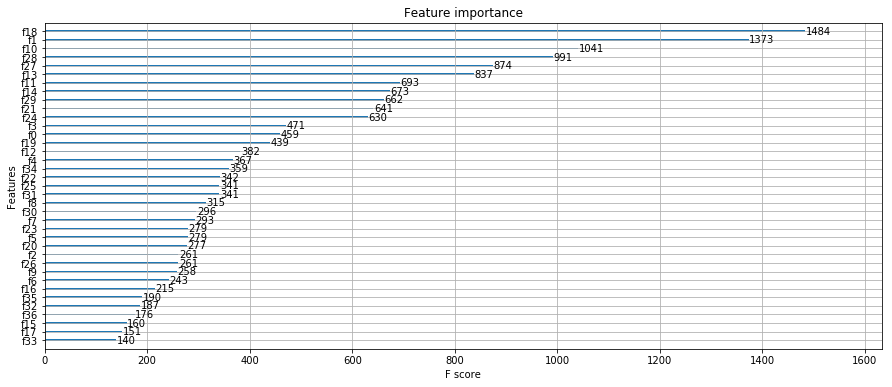

In [29]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(model)
plt.show()
#for i,f in enumerate(features):
#    print(i,f)

In [30]:
#matrix.to_c_sv('matrix.csv')
#rf_test_y = rf_model.predict(test_x)
#rf_test_y = pd.DataFrame(test_y, columns = ['item_cnt_month'])
#test_y['ID'] = test_y.index
#test_y = test_y.set_index('ID')
#matrix[['item_category_id','category_mean_code']][(matrix.date_block_num==22)]

* <a href="1st_xgb.csv"> Download File </a>

In [31]:
#submit=matrix[(matrix.date_block_num==test_time)]
#submit.loc[:,'item_cnt']=test_y

In [32]:
#submit=pd.merge(test,submit,on=['shop_id','item_id'],how='left')


In [33]:
#submit= pd.DataFrame(submit.item_cnt.values, columns = ['item_cnt_month'])
#submit['ID'] = submit.index
#submit = submit.set_index('ID')
#submit.to_csv('3rd_xgb_submit.csv')

test_y=pd.DataFrame(test_y, columns = ['item_cnt_month'])
test_y['ID'] = test_y.index
test_y = test_y.set_index('ID')
test_y.to_csv('3rd_xgb_submit.csv')

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

1. * <a href="3rd_xgb_submit.csv"> Download File </a>

In [34]:
test_y

,item_cnt_month
ID,
0,0.666049
1,0.471365
2,1.168807
3,0.410341
4,1.724147
5,0.675673
6,0.968839
7,0.121985
8,1.016301
